## Modelling Draft: Xception for M-Stage Classification<br>
Framework: Tensorflow Keras <br>
Base models to test: <br>
<li>Xception ✓</li>
<li>MobileNet </li>
<li>NasNet Mobile </li>

#### Import Packages

In [2]:
# from PIL import Image
# from tensorflow.keras import backend as K
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow
import random
import os
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout, BatchNormalization, Flatten, Input
from tensorflow.keras.optimizers import *
from tensorflow.keras.metrics import *
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input
from sklearn.model_selection import train_test_split
from sklearn.metrics._plot.confusion_matrix import ConfusionMatrixDisplay
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import class_weight
from time import perf_counter

import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000
pd.set_option('display.max_colwidth', None)  # or 199
print ('All modules are loaded')

All modules are loaded


In [3]:
#Labels
# t_stg= ['is','1','1a','1b','1c','2','2a','2b','3','4']
# n_stg = ['0','1','2','3']
m_stg = ['0','1','1a','1b','1c','2','3'] 

#Load the image batches, labels == t,m,n
m_raw_df = pd.read_csv(r'D:\Lung-PET-CT-Dx\manifest\raw_ct_delimited.csv',usecols=['filenames','m'])
raw_dir = r'C:\Users\lzsnc\Desktop\Raw CT resized'
m_raw_df.head()
os.chdir(r'C:\Users\lzsnc\Desktop\Raw CT resized')

In [4]:
m_raw_df.head()

,filenames,m
0,Lung_Dx-A0001_04-04-2007-NA-Chest-07990_2.000000-5mm-40805_1-13.tiff,1b
1,Lung_Dx-A0001_04-04-2007-NA-Chest-07990_2.000000-5mm-40805_1-14.tiff,1b
2,Lung_Dx-A0001_04-04-2007-NA-Chest-07990_2.000000-5mm-40805_1-15.tiff,1b
3,Lung_Dx-A0001_04-04-2007-NA-Chest-07990_2.000000-5mm-40805_1-16.tiff,1b
4,Lung_Dx-A0001_04-04-2007-NA-Chest-07990_2.000000-5mm-40805_1-17.tiff,1b


#### Split Dataset: <br>
80% Train, 20% Test

In [5]:
m_train_df, m_test_df = train_test_split(m_raw_df, test_size=0.2, random_state=42) 
m_train_df.tail()
#convert m-stage df to string
m_train_df['m'] = m_train_df['m'].apply(str)
m_test_df['m'] = m_test_df['m'].apply(str)

#### Train/Test for 'T' Stage

In [6]:
train_batch = 32
train_datagen = ImageDataGenerator(rescale=1 / 255.0,
                                   featurewise_center=True,
                                   featurewise_std_normalization=True,)

m_train_ds = train_datagen.flow_from_dataframe(
    dataframe=m_train_df,
    directory=raw_dir,
    x_col='filenames',
    y_col='m',
    # color_mode='grayscale',
    class_mode='categorical',
    shuffle=True,
    seed=32
)

Found 24250 validated image filenames belonging to 7 classes.


#### Test Image Generator

In [7]:
test_batch = 32
test_datagen = ImageDataGenerator(rescale=1 / 255.0)
m_test_ds = test_datagen.flow_from_dataframe(
    dataframe=m_test_df,
    directory=raw_dir,
    x_col='filenames',
    y_col='m',
    # color_mode='grayscale',
    class_mode='categorical',
    shuffle=False, #re-run this!
    seed=32 
)

Found 6063 validated image filenames belonging to 7 classes.


In [8]:
m_class_dict = m_train_ds.class_indices
print(m_class_dict)
m_num_classes = len(m_class_dict)
m_num_classes

{'0': 0, '1': 1, '1a': 2, '1b': 3, '1c': 4, '2': 5, '3': 6}


7

In [9]:
m_class_dict

{'0': 0, '1': 1, '1a': 2, '1b': 3, '1c': 4, '2': 5, '3': 6}

Try adding weights

In [10]:
m_class_weights = class_weight.compute_class_weight(
           class_weight='balanced',
           classes=np.unique(m_train_ds.classes),
           y=m_train_ds.classes)
m_class_weights = dict(zip(np.unique(m_train_ds.classes), m_class_weights))
m_class_weights

{0: 0.2078155797411946,
 1: 0.7223281305850113,
 2: 4.390729675900778,
 3: 3.025577043044292,
 4: 4.229897087039944,
 5: 247.44897959183675,
 6: 203.78151260504202}

Model 3: Xception

In [11]:
base_model = Xception(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)
base_model.trainable = False
base_model.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 111, 111, 32)         864       ['input_1[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 111, 111, 32)         128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  (None, 111, 111, 32)         0         ['block1_conv1_bn[0][0]

In [12]:
#Add random seed
seed_value = 42
random.seed(seed_value)
np.random.seed(seed_value)
tensorflow.random.set_seed(seed_value) #use in dropout

In [13]:
#Create the model
model = Sequential()
model.add(base_model)
# model.add(Dropout(0.3))
model.add(tensorflow.keras.layers.GlobalAveragePooling2D())
model.add(BatchNormalization(axis = -1, momentum = 0.99, epsilon = 0.001))
model.add(tensorflow.keras.layers.Reshape((-1,1)))
model.add(tensorflow.keras.layers.AveragePooling1D())
model.add(Flatten())
model.add(Dropout(0.3,seed=seed_value))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3,seed=seed_value))
model.add(Dense(m_num_classes,activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 batch_normalization_4 (Bat  (None, 2048)              8192      
 chNormalization)                                                
                                                                 
 reshape (Reshape)           (None, 2048, 1)           0         
                                                                 
 average_pooling1d (Average  (None, 1024, 1)           0         
 Pooling1D)                                                      
                                                        

In [14]:
learning_rate = 0.0001
optimizer = tensorflow.keras.optimizers.Adam(learning_rate=learning_rate)
loss = tensorflow.keras.losses.CategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

Actual Training

In [15]:
os.chdir(r'D:\Lung-PET-CT-Dx\manifest\Models')
checkpoint_callback = tensorflow.keras.callbacks.ModelCheckpoint("multiclass_m_stage_xception_v2.h5",
                     save_best_only=True, # only keep the best model weights on file (delete the rest)
                     save_weights_only=False,   # save only the model weights
                     verbose=1, # don't print out whether or not model is being saved
                     monitor='val_loss')
                    #  mode='max') # save the model weights which score the best validation accuracy
early_stop = tensorflow.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                              mode='auto',
                                              patience=5)

In [16]:
start = perf_counter()
history = model.fit(m_train_ds,
                    epochs=20,
                    steps_per_epoch=len(m_train_ds),
                    validation_data=m_test_ds,
                    validation_steps=len(m_test_ds),
                    callbacks=[checkpoint_callback, early_stop],
                    verbose=1,
                    class_weight=m_class_weights)
end = perf_counter()
print(end - start)


Epoch 1/20
758/758 [==============================] - ETA: 0s - loss: 1.9317 - accuracy: 0.3000
Epoch 1: val_loss improved from inf to 1.64336, saving model to multiclass_m_stage_xception_v2.h5
758/758 [==============================] - 2045s 3s/step - loss: 1.9317 - accuracy: 0.3000 - val_loss: 1.6434 - val_accuracy: 0.3002
Epoch 2/20
758/758 [==============================] - ETA: 0s - loss: 1.4048 - accuracy: 0.2732
Epoch 2: val_loss improved from 1.64336 to 1.60941, saving model to multiclass_m_stage_xception_v2.h5
758/758 [==============================] - 2010s 3s/step - loss: 1.4048 - accuracy: 0.2732 - val_loss: 1.6094 - val_accuracy: 0.2900
Epoch 3/20
758/758 [==============================] - ETA: 0s - loss: 1.1891 - accuracy: 0.2883
Epoch 3: val_loss improved from 1.60941 to 1.47460, saving model to multiclass_m_stage_xception_v2.h5
758/758 [==============================] - 2015s 3s/step - loss: 1.1891 - accuracy: 0.2883 - val_loss: 1.4746 - val_accuracy: 0.3246
Epoch 4/20


Load model - skip training <br>
Approximate training time: 10 hours 14 mins 20 secs

In [17]:
#Evaluate performance
def plot_loss_curves(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

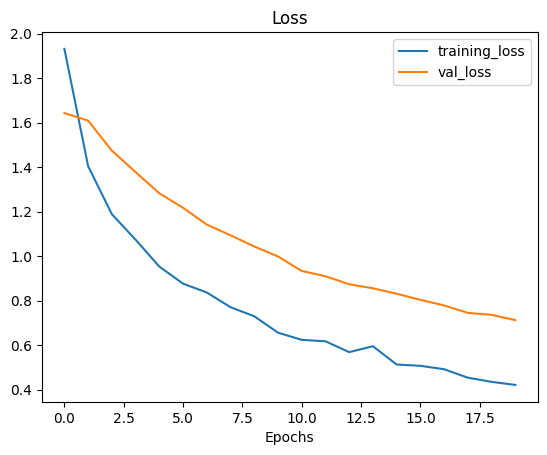

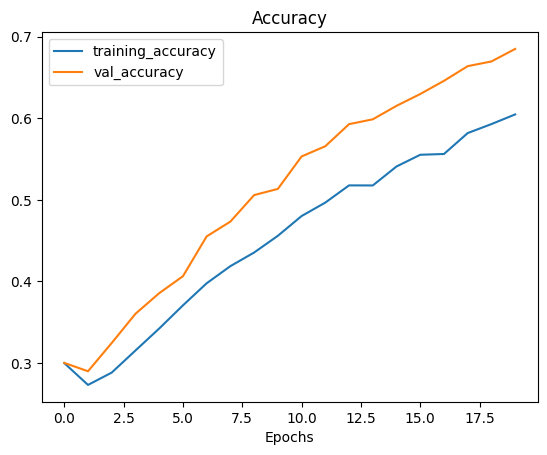

In [18]:
plot_loss_curves(history)

190/190 [==============================] - 436s 2s/step
Confusion Matrix
Classification Report for M-Stage
              precision    recall  f1-score   support

           0       0.96      0.59      0.74      4181
           1       0.56      0.84      0.67      1249
          1a       0.28      0.98      0.44       174
          1b       0.47      0.98      0.63       269
          1c       0.43      0.98      0.60       184
           2       0.67      1.00      0.80         2
           3       0.29      1.00      0.44         4

    accuracy                           0.68      6063
   macro avg       0.52      0.91      0.62      6063
weighted avg       0.82      0.68      0.70      6063



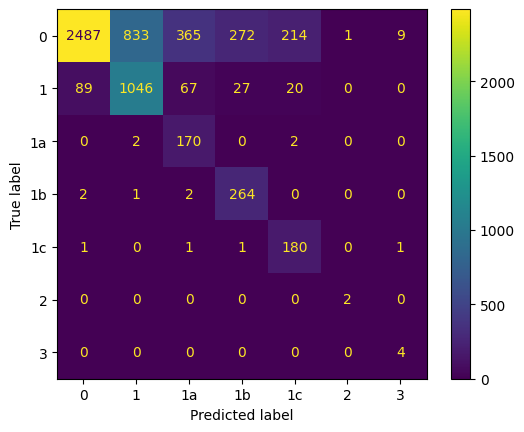

In [19]:
# m_stg = ['0','1','1a','1b','1c','2','3'] 
# t_Y_pred = model.predict(t_test_ds)
m_Y_pred = model.predict(m_test_ds) #predictions
m_Y_ground = m_test_df.m.to_list()
m_y_pred = np.argmax(m_Y_pred,axis=1)
print('Confusion Matrix')
cm = confusion_matrix(m_test_ds.classes, m_y_pred)
# cm = confusion_matrix(t_Y_ground, t_Y_pred,normalize='true')
cmd = ConfusionMatrixDisplay(cm, display_labels=m_stg)
cmd.plot()

print('Classification Report for M-Stage')

print(classification_report(m_test_ds.classes, m_y_pred, target_names=m_stg))


In [20]:
from tensorflow.keras.preprocessing import image
test_img = r'C:\Users\lzsnc\Desktop\Raw CT Images\Lung_Dx-A0065_10-26-2008-NA-lungc-32319_3.000000-5mm Lung SS50-68818_1-34.tiff'
test = image.load_img(test_img, target_size=(224,224))
test_img_array = image.img_to_array(test)
img_batch = np.expand_dims(test_img_array, axis=0)
img_preprocessed = preprocess_input(img_batch)
prediction = model.predict(img_preprocessed)
print(prediction[0])

1/1 [==============================] - 1s 855ms/step
[1.0057821e-01 1.2950223e-02 8.2656151e-01 5.6142170e-02 1.1416124e-04
 3.1229882e-03 5.3079048e-04]
